In [1]:
import glob
import random
import pandas as pd
from IPython.display import Image

from functools import partial
from multiprocessing import Pool

import numpy as np

import sklearn



In [2]:
path = 'A_basins_total_upstrm/2_timeseries/daily'
files = glob.glob(path+'/*')

In [3]:
Image(url="https://zenodo.org/api/iiif/v2/5e7b63a7-7bea-46f6-a8ac-00d63e3cb9b1:c5697b0f-87ce-4b8d-94b2-a8296e3367d1:LamaH_banner.png/full/750,/0/default.png", width=300, height=300)


In [4]:
random_number=1
shuff = True
random.seed(random_number)
if shuff:
    random.shuffle(files)
    files = files[:100]
else:
    files=files[:100]

In [5]:
df_list = (pd.read_csv(file,delimiter=';') for file in files)

In [6]:
# We also need to extract what file they came from for the ID
df = pd.DataFrame()
for i,df2 in enumerate(df_list):
    df2["id"]=int(files[i].split("ID_")[1].strip(".csv"))
    df   = pd.concat([df,df2], ignore_index=True)

In [7]:
#df   = pd.concat(df_list, ignore_index=True)

In [8]:
df.head(5)

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,surf_net_solar_rad_max,surf_net_solar_rad_mean,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,id
0,1981,1,1,1,-3.5,-6.2,-9.8,-5.7,-9.1,-13.3,...,98,15,55,23,85340.0,0.01,9.94,0.34,0.4,636
1,1981,1,2,2,-3.7,-5.9,-7.4,-5.8,-8.2,-9.2,...,68,14,20,10,85292.0,0.18,17.13,0.33,0.4,636
2,1981,1,3,3,0.4,-1.1,-3.3,-1.2,-4.0,-6.2,...,79,18,38,13,84390.0,0.28,14.63,0.33,0.4,636
3,1981,1,4,4,-0.1,-3.0,-6.9,-1.2,-4.2,-9.5,...,28,6,74,21,83775.0,0.28,30.29,0.33,0.4,636
4,1981,1,5,5,-7.8,-9.3,-10.1,-10.5,-11.5,-12.1,...,86,16,49,20,84490.0,0.39,18.90,0.33,0.4,636


In [9]:
#column_to_move = df.pop("prec")
#df.insert(len(df.columns), "prec", column_to_move)

In [10]:
# time is a counter per group. Later used to filter out first x Observations for each group
df['time'] = df.groupby('id').cumcount()

# the indipendent variables
var_cols=['2m_temp_max', '2m_temp_mean', '2m_temp_min',
       '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u',
       '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe',
       'surf_net_solar_rad_max', 'surf_net_solar_rad_mean',
       'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press',
       'total_et', 'volsw_123', 'volsw_4',"prec"]

In [11]:
# Target variable is the perc once shifted
df["target"] = df["prec"].shift(periods=-1)

In [12]:
import warnings
warnings.filterwarnings('ignore')

# creating means and lagging columns per inidpendent variable
for col in var_cols:
    
    df[col+"_mean_3d"] = df[col].rolling(3).mean()
    df[col+"_std_3d"] = df[col].rolling(3).std()
    
    df[col+"_mean_7d"] = df[col].rolling(7).mean()
    df[col+"_std_7d"] = df[col].rolling(7).std()
    
    df[col+"_mean_30d"] = df[col].rolling(30).mean()
    df[col+"_std_30d"] = df[col].rolling(30).std()

    df[col+"_mean_365d"] = df[col].rolling(30).mean()
    df[col+"_std_365d"] = df[col].rolling(30).std()

    # Create features using differencing
    df[col+"_diff_1d"] = df[col].diff(1)
    df[col+"_diff_2d"] = df[col].diff(2)
    df[col+"_diff_365d"] = df[col].diff(365)

    # Create features using lagging
    df[col+"_lag_1d"] = df[col].shift(periods=1)
    df[col+"_lag_2d"] = df[col].shift(periods=2)
    df[col+"_lag_365d"] = df[col].shift(periods=365)

    # shifted mean
    df[col+"_lag350_mean15"] = df[col].shift(periods=350).rolling(15).mean()

    #break
    
#df.head(10)



In [13]:
# fist 366 have nans since i cant build the average or lag if i dont have the data
df =df.loc[df["time"]>366]


# valid set is from 2016 till 2019 (inclusive)
train = df.loc[df["YYYY"]<2016]
valid = df.loc[df["YYYY"]>=2016]

# we dont know what the actual y for the prediction of the last day is so we need to drop it
valid=valid.loc[~((valid["YYYY"]==2019) & (valid["MM"]==12) & (valid["DD"]==31))]

train=train.drop(["YYYY","MM","DD","DOY","id","time"],axis=1)
valid=valid.drop(["YYYY","MM","DD","DOY","id","time"],axis=1)




X_train = train.drop("target", axis=1)
X_valid = valid.drop("target", axis=1)
y_train = train["target"]
y_valid = valid["target"]


## Feature Selection with Lasso

In [14]:
%%time
if False:

    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import Lasso

    pipeline = Pipeline([
                         ('scaler',StandardScaler()),
                         ('model',Lasso(0.1))
    ])


    pipeline.fit(X_train,y_train)


    coefficients = pipeline.named_steps['model'].coef_

    importance = np.abs(coefficients)

    selected= np.array(X_train.columns)[importance > 0]

    #X_train_selected = X_train[selected]
    #X_valid_selected = X_valid[selected]

CPU times: total: 0 ns
Wall time: 621 µs


CPU times: total: 25min 20s
Wall time: 5min 2s

In [15]:
selected=['2m_dp_temp_min', '10m_wind_u', '10m_wind_v',
       'surf_net_solar_rad_max', 'surf_net_therm_rad_mean', 'surf_press',
       'prec', '2m_temp_mean_diff_1d', '2m_temp_mean_diff_365d',
       '2m_dp_temp_min_diff_1d', '10m_wind_u_std_30d',
       '10m_wind_u_lag_1d', '10m_wind_v_mean_7d', '10m_wind_v_std_30d',
       '10m_wind_v_std_365d', '10m_wind_v_diff_1d', '10m_wind_v_lag_2d',
       'lai_high_veg_lag350_mean15', 'swe_std_30d', 'surf_press_std_3d',
       'surf_press_diff_1d', 'surf_press_diff_365d', 'total_et_lag_1d',
       'volsw_123_diff_1d', 'volsw_4_lag_365d', 'prec_mean_3d',
       'prec_mean_7d', 'prec_mean_30d', 'prec_mean_365d', 'prec_lag_365d',
       'prec_lag350_mean15']

In [16]:
df[["prec","target"]]


,prec,target
367,0.30,1.65
368,1.65,11.13
369,11.13,22.34
370,22.34,0.96
371,0.96,16.74
...,...,...
1424395,4.27,0.17
1424396,0.17,0.00
1424397,0.00,0.00
1424398,0.00,0.00


In [17]:
X_train_selected = X_train[selected]
X_valid_selected = X_valid[selected]

In [29]:
print(valid["target"].mean())
print(((valid["target"]**2)).mean()**0.5)
X_train_selected

3.3801019863016046
6.567593228763081


,2m_dp_temp_min,10m_wind_u,10m_wind_v,surf_net_solar_rad_max,surf_net_therm_rad_mean,surf_press,prec,2m_temp_mean_diff_1d,2m_temp_mean_diff_365d,2m_dp_temp_min_diff_1d,...,surf_press_diff_365d,total_et_lag_1d,volsw_123_diff_1d,volsw_4_lag_365d,prec_mean_3d,prec_mean_7d,prec_mean_30d,prec_mean_365d,prec_lag_365d,prec_lag350_mean15
367,-7.2,0.1,1.6,166,37,85359.0,0.30,2.1,-0.6,2.3,...,969.0,0.21,0.00,0.40,6.490000e+00,4.142857,6.605000,6.605000,14.63,9.364667
368,-6.3,0.7,1.3,99,30,85008.0,1.65,-0.3,1.0,0.9,...,1233.0,0.08,0.00,0.40,1.210000e+00,4.377143,6.408333,6.408333,30.29,8.372000
369,-4.3,0.9,1.3,109,25,84712.0,11.13,1.3,8.6,2.0,...,222.0,0.05,0.00,0.40,4.360000e+00,5.605714,6.745000,6.745000,18.90,8.181333
370,-10.7,1.4,0.0,53,14,84201.0,22.34,-1.6,6.9,-6.4,...,-131.0,0.12,0.01,0.40,1.170667e+01,8.572857,7.099333,7.099333,22.35,6.962000
371,-17.5,0.1,-0.7,147,51,84967.0,0.96,-10.2,-0.3,-6.8,...,-177.0,0.45,0.00,0.40,1.147667e+01,7.935714,6.664667,6.664667,10.93,6.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422934,-25.2,0.1,0.2,108,39,74704.0,0.00,-0.6,9.2,-6.7,...,2685.0,0.00,0.00,0.36,1.207923e-13,0.014286,0.555667,0.555667,4.94,3.958000
1422935,-26.2,0.0,0.4,109,35,74564.0,0.00,1.2,11.0,-1.0,...,2531.0,0.00,0.00,0.36,1.207923e-13,0.000000,0.499333,0.499333,2.48,3.867333
1422936,-20.9,0.2,-0.1,112,38,74255.0,0.00,-1.1,13.2,5.3,...,1051.0,0.00,0.00,0.36,1.207923e-13,0.000000,0.443667,0.443667,4.68,3.555333
1422937,-19.4,-0.1,0.6,113,42,74056.0,0.00,-2.1,9.7,1.5,...,511.0,0.00,0.00,0.36,1.207923e-13,0.000000,0.430000,0.430000,8.05,3.176000


## Linear Regression

In [19]:
%%time
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train_selected,y_train)

CPU times: total: 5.84 s
Wall time: 4.34 s


LinearRegression()

In [20]:
y_pred=model.predict(X_valid_selected)

from sklearn.metrics import mean_squared_error, mean_absolute_error

rms = mean_squared_error(y_valid, y_pred, squared=False)
print(rms)
mae = mean_absolute_error(y_valid, y_pred)
print(mae)

5.109918837759838
3.3299322677226955


## Random Forest

In [39]:
%%time
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=20,random_state=random_number,max_depth=10,n_jobs=-1)
model.fit(X_train_selected,y_train)
y_pred=model.predict(X_valid_selected)
rms2 = mean_squared_error(y_valid, y_pred, squared=False)
print(rms2)
mae2 = mean_absolute_error(y_valid, y_pred)
print(mae2)

5.042502644989404
3.188845126767508
CPU times: total: 24min 47s
Wall time: 3min 37s


5.048991799438373
3.1909034309809523
CPU times: total: 3min 56s
Wall time: 44.8 s

In [36]:
if False:
    %%time
    from sklearn.ensemble import RandomForestRegressor
    model=RandomForestRegressor(n_estimators=10,random_state=random_number,max_depth=10,n_jobs=-1)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_valid)
    rms2 = mean_squared_error(y_valid, y_pred, squared=False)
    rms2

CPU times: total: 55min 21s
Wall time: 10min 6s
5.056492392315354

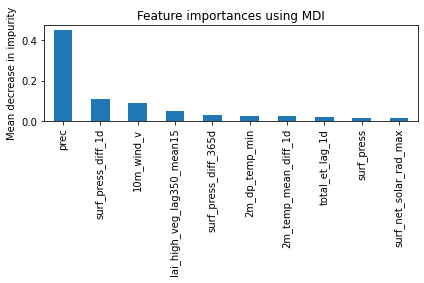

In [37]:
from matplotlib import pyplot as plt
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)

#forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances = pd.concat([pd.Series(importances), pd.Series(std)],axis=1, ignore_index=True)

forest_importances.index=X_train_selected.columns
forest_importances = forest_importances.sort_values(0,ascending=False)


forest_importances = forest_importances.iloc[:10]

fig, ax = plt.subplots()
forest_importances[0].plot.bar(yerr=forest_importances[1], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## MLP Regressor

In [38]:
%%time
from sklearn.neural_network import MLPRegressor
model=MLPRegressor(random_state=random_number)
model.fit(X_train_selected,y_train)
y_pred=model.predict(X_valid_selected)
rms3 = mean_squared_error(y_valid, y_pred, squared=False)
print(rms3)
mae3 = mean_absolute_error(y_valid, y_pred)
print(mae3)

6.8102581623454705
5.999692004457519
CPU times: total: 1h 6min 52s
Wall time: 1h 30min 38s


6.8102581623454705

5.999692004457519

CPU times: total: 1h 6min 52s

Wall time: 1h 30min 38s

## Histogram-Based Gradient Boosting Regression

In [22]:
%%time
from sklearn.ensemble import HistGradientBoostingRegressor
model=HistGradientBoostingRegressor(random_state=random_number)
model.fit(X_train_selected,y_train)
y_pred=model.predict(X_valid_selected)
rms3 = mean_squared_error(y_valid, y_pred, squared=False)
print(rms3)
mae3 = mean_absolute_error(y_valid, y_pred)
print(mae3)

4.950328576205458
3.1198623668528502
CPU times: total: 2min 3s
Wall time: 17.1 s


## DecisionTreeRegressor


In [21]:
%%time

from sklearn import tree
model=tree.DecisionTreeRegressor()
model.fit(X_train_selected,y_train)
y_pred=model.predict(X_valid_selected)
rms4 = mean_squared_error(y_valid, y_pred, squared=False)
print(rms4)
mae4 = mean_absolute_error(y_valid, y_pred)
print(mae4)

7.184957456714307
4.1837489041095886
CPU times: total: 1min 8s
Wall time: 1min 8s


In [22]:
df

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,prec_std_30d,prec_mean_365d,prec_std_365d,prec_diff_1d,prec_diff_2d,prec_diff_365d,prec_lag_1d,prec_lag_2d,prec_lag_365d,prec_lag350_mean15
367,1982,1,3,3,1.8,-1.7,-5.2,-1.4,-4.5,-7.2,...,6.813490,6.605000,6.813490,-1.38,-17.19,-14.33,1.68,17.49,14.63,9.364667
368,1982,1,4,4,1.9,-2.0,-5.2,-2.3,-4.6,-6.3,...,6.870186,6.408333,6.870186,1.35,-0.03,-28.64,0.30,1.68,30.29,8.372000
369,1982,1,5,5,1.2,-0.7,-2.0,-1.5,-3.1,-4.3,...,6.844962,6.745000,6.844962,9.48,10.83,-7.77,1.65,0.30,18.90,8.181333
370,1982,1,6,6,0.3,-2.3,-9.1,-1.7,-3.9,-10.7,...,7.366134,7.099333,7.366134,11.21,20.69,-0.01,11.13,1.65,22.35,6.962000
371,1982,1,7,7,-9.7,-12.5,-15.3,-11.2,-15.2,-17.5,...,7.329539,6.664667,7.329539,-21.38,-10.17,-9.97,22.34,11.13,10.93,6.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424395,2019,12,27,361,-7.9,-9.5,-11.1,-9.3,-11.1,-13.7,...,3.315349,3.437000,3.315349,3.60,-3.82,4.27,0.67,8.09,0.00,5.250000
1424396,2019,12,28,362,-8.7,-10.9,-12.6,-10.6,-16.6,-25.8,...,3.365881,3.355667,3.365881,-4.10,-0.50,0.15,4.27,0.67,0.02,5.402000
1424397,2019,12,29,363,-8.5,-10.9,-14.0,-20.5,-27.2,-31.3,...,3.380685,3.154667,3.380685,-0.17,-4.27,0.00,0.17,4.27,0.00,7.146667
1424398,2019,12,30,364,-7.9,-10.6,-12.5,-14.7,-18.3,-25.7,...,3.398817,3.133667,3.398817,0.00,-0.17,-4.27,0.00,0.17,4.27,8.465333


In [24]:
X_train_selected

,2m_dp_temp_min,10m_wind_u,10m_wind_v,surf_net_solar_rad_max,surf_net_therm_rad_mean,surf_press,prec,2m_temp_mean_diff_1d,2m_temp_mean_diff_365d,2m_dp_temp_min_diff_1d,...,surf_press_diff_365d,total_et_lag_1d,volsw_123_diff_1d,volsw_4_lag_365d,prec_mean_3d,prec_mean_7d,prec_mean_30d,prec_mean_365d,prec_lag_365d,prec_lag350_mean15
367,-7.2,0.1,1.6,166,37,85359.0,0.30,2.1,-0.6,2.3,...,969.0,0.21,0.00,0.40,6.490000e+00,4.142857,6.605000,6.605000,14.63,9.364667
368,-6.3,0.7,1.3,99,30,85008.0,1.65,-0.3,1.0,0.9,...,1233.0,0.08,0.00,0.40,1.210000e+00,4.377143,6.408333,6.408333,30.29,8.372000
369,-4.3,0.9,1.3,109,25,84712.0,11.13,1.3,8.6,2.0,...,222.0,0.05,0.00,0.40,4.360000e+00,5.605714,6.745000,6.745000,18.90,8.181333
370,-10.7,1.4,0.0,53,14,84201.0,22.34,-1.6,6.9,-6.4,...,-131.0,0.12,0.01,0.40,1.170667e+01,8.572857,7.099333,7.099333,22.35,6.962000
371,-17.5,0.1,-0.7,147,51,84967.0,0.96,-10.2,-0.3,-6.8,...,-177.0,0.45,0.00,0.40,1.147667e+01,7.935714,6.664667,6.664667,10.93,6.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422934,-25.2,0.1,0.2,108,39,74704.0,0.00,-0.6,9.2,-6.7,...,2685.0,0.00,0.00,0.36,1.207923e-13,0.014286,0.555667,0.555667,4.94,3.958000
1422935,-26.2,0.0,0.4,109,35,74564.0,0.00,1.2,11.0,-1.0,...,2531.0,0.00,0.00,0.36,1.207923e-13,0.000000,0.499333,0.499333,2.48,3.867333
1422936,-20.9,0.2,-0.1,112,38,74255.0,0.00,-1.1,13.2,5.3,...,1051.0,0.00,0.00,0.36,1.207923e-13,0.000000,0.443667,0.443667,4.68,3.555333
1422937,-19.4,-0.1,0.6,113,42,74056.0,0.00,-2.1,9.7,1.5,...,511.0,0.00,0.00,0.36,1.207923e-13,0.000000,0.430000,0.430000,8.05,3.176000
